# Constructing the MGC subgraph
Vivek Gopalakrishnan | February 25, 2019

## Overview:
Graphs are constructed of nodes. Nodes that contain information about the batch that a connectome come from confound scientific inquiry. So let's identify those nodes and remove them!

Nodes not correlated with batch labels will be identified using MGC and used to construct a subgraph.

## Contents
1. Import data and embed
2. Measure correlation of node with batch label using MGC

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import networkx as nx
import graspy as gs
from graspy.utils import import_graph

from collections import OrderedDict
import os

### 1. Import data and embed

**PROCEDURE:**
1. Import the data
2. Transform using `cMDS o omni o PTR`
3. Visualize via pair plot for sanity

In [2]:
hbn = []
hnu = []

# Load HBN
for root, dirs, files in os.walk('../../data/HBN'):
    
    for graph in files:
        if graph.endswith(".edgelist"):
            graph_path = os.path.join(root, graph)
            G = nx.read_weighted_edgelist(graph_path)
            G = gs.utils.pass_to_ranks(G)
            if G.shape == (70, 70):
                hbn.append(G)
            
# Load HNU1
for root, dirs, files in os.walk('../../data/HNU1'):
    
    for graph in files:
        if graph.endswith(".edgelist"):
            graph_path = os.path.join(root, graph)
            G = nx.read_edgelist(graph_path)
            G = gs.utils.pass_to_ranks(G)
            if G.shape == (70, 70):
                hnu.append(G)

# Convert to numpy array
hbn = np.array(hbn)
hnu = np.array(hnu)
print("Number of patients in HBN: {}".format(len(hbn)))
print("Number of patients in HNU1: {}".format(len(hnu)))

Number of patients in HBN: 99
Number of patients in HNU1: 300


In [3]:
def embed(data, n_components=50, n_population=75):
    """Embed a subset of an array of connectomes (data) in specified number of dimensions."""
    
    omni = gs.embed.OmnibusEmbed(n_components=n_components)
    Zhat = omni.fit_transform(
        data[np.random.choice(len(data), size=n_population)]
    )
    
    return Zhat

In [4]:
# Constants
n_components = 50
n_population = 50

# Embed the data
Zhat_hbn = embed(hbn, n_population=n_population)
Zhat_hnu = embed(hnu, n_population=n_population)

# Verify embedding shapes for sanity
print(Zhat_hbn.shape)
print(Zhat_hnu.shape)

(3500, 50)
(3500, 50)


In [5]:
# Combine embeddings
Zhat = np.vstack([Zhat_hbn, Zhat_hnu])
print(Zhat.shape)

# Tensor: subject x node x Euclidean representation
Zhat = Zhat.reshape((n_population * 2, 70, -1))
print(Zhat.shape)

(7000, 50)
(100, 70, 50)


### Identify non-essential nodes using MGC

`# Iterate over nodes by Zhat[:,i,:]`

In [6]:
from collections import OrderedDict

import seaborn as sns
from mgcpy.independence_tests.mgc.mgc import MGC

In [7]:
batch = np.array([-1]*n_population + [1]*n_population).reshape(-1,1)

In [8]:
mgc = MGC()
stats = OrderedDict()

for i in range(Zhat.shape[1]):
    mgc_statistic, independence_test_metadata = mgc.test_statistic(Zhat[:,i,:], batch,)
    stats[i] = mgc_statistic

Text(0.5, 0, 'mgc_statistic')

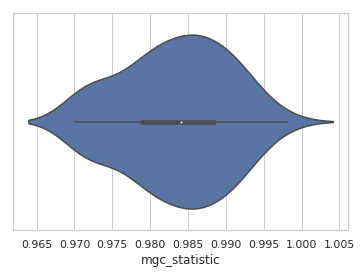

In [9]:
sns.set(style="whitegrid")
ax = sns.violinplot(x=list(stats.values()))
ax.set_xlabel("mgc_statistic")